# Libs and pre-definitions

## Import libs

In [1]:
import sys
sys.path.append('/home/luis-felipe/brats_lf/src')
sys.path.insert(1, '../src')

In [2]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

import metrics
import get_data as gd
import models_nn 
import train_and_eval as TE
import utils

## Paths

In [3]:
torch.cuda.empty_cache()
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
PROJ_ROOT = os.path.join(os.path.abspath(os.pardir))
PROJ_ROOT

'/home/luis-felipe/brats_lf'

In [5]:
class GlobalConfig:
    
    root_dir = os.path.join(PROJ_ROOT,'data')
    train_root_dir =os.path.join(root_dir, 'BraTS2020_TrainingData','MICCAI_BraTS2020_TrainingData')
    test_root_dir = os.path.join(root_dir, 'BraTS2020_TrainingData','MICCAI_BraTS2020_ValidationData')
    path_to_csv = os.path.join(root_dir,'train_data.csv')
    pretrained_model_path = os.path.join(PROJ_ROOT,'brats2020logs','unet','last_epoch_model.pth')
    train_logs_path = os.path.join(PROJ_ROOT,'brats2020logs','unet','train_log.csv')
    ae_pretrained_model_path = os.path.join(PROJ_ROOT,'brats2020logs','ae','autoencoder_best_model.pth')
    tab_data = os.path.join(PROJ_ROOT,'brats2020logs','data','df_with_voxel_stats_and_latent_features.csv')
    seed = 55

    
config = GlobalConfig()
utils.seed_everything(config.seed)

# Data

In [6]:
dataloader = gd.get_dataloader(dataset=gd.BratsDataset, path_to_csv='train_data.csv', phase='train', fold=0)
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

val_dataloader = gd.get_dataloader(gd.BratsDataset, 'train_data.csv', phase='valid', fold=0)

# Define model and trainer

In [14]:
model = models_nn.UNet3d(in_channels=4, n_classes=3, n_channels=24).to(dev)
trainer = TE.Trainer_unet(net=model,
                  dataset=gd.BratsDataset,
                  criterion=metrics.BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  fold=0,
                  num_epochs=5,
                  path_to_csv = config.path_to_csv)

if config.pretrained_model_path is not None:
    TE.pre_trainer(trainer,config)

device: cuda
Predtrain model loaded


## Train

In [10]:
%%time
trainer.run()

train epoch: 0 | time: 14:07:41


RuntimeError: CUDA out of memory. Tried to allocate 408.00 MiB (GPU 0; 7.79 GiB total capacity; 5.34 GiB already allocated; 398.19 MiB free; 5.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Results

In [19]:
model = model.cpu()
model.eval()

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [20]:
%%time
dice_scores_per_classes, iou_scores_per_classes = TE.compute_scores_per_classes(
    model, val_dataloader, ['WT', 'TC', 'ET'])

CPU times: user 21min 3s, sys: 9min 37s, total: 30min 41s
Wall time: 6min 1s


In [21]:
import pandas as pd
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard', 
                                      'TC dice', 'TC jaccard', 
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)

,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
4,0.966087,0.934398,0.665297,0.498460,0.908794,0.832834
9,0.718893,0.561150,0.896990,0.813220,0.822355,0.698305
27,0.935288,0.878442,0.875065,0.777880,0.766614,0.621552
2,0.866544,0.764514,0.262370,0.150993,0.101085,0.053233
20,0.818221,0.692363,0.853458,0.744375,0.799257,0.665635


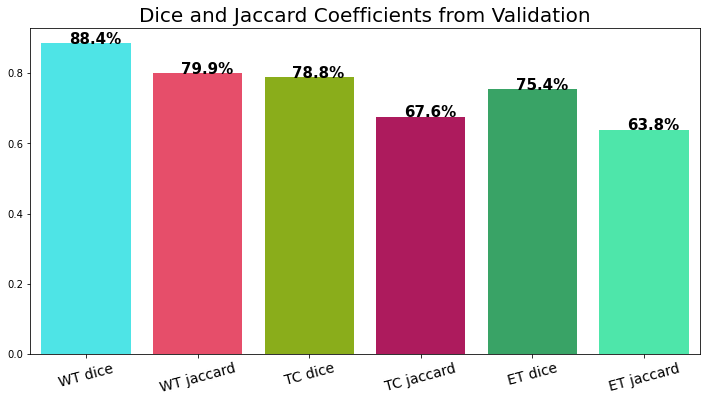

In [23]:
import seaborn as sns
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')